Veri seti başarıyla yüklendi!
                                                                          0  \
track_id                                             6f807x0ima9a1j3VPbc7VN   
track_name                I Don't Care (with Justin Bieber) - Loud Luxur...   
track_artist                                                     Ed Sheeran   
track_popularity                                                         66   
track_album_id                                       2oCs0DGTsRO98Gh5ZSl2Cx   
track_album_name          I Don't Care (with Justin Bieber) [Loud Luxury...   
track_album_release_date                                         2019-06-14   
playlist_name                                                     Pop Remix   
playlist_id                                          37i9dQZF1DXcZDD7cfEKhW   
playlist_genre                                                          pop   
playlist_subgenre                                                 dance pop   
danceability          

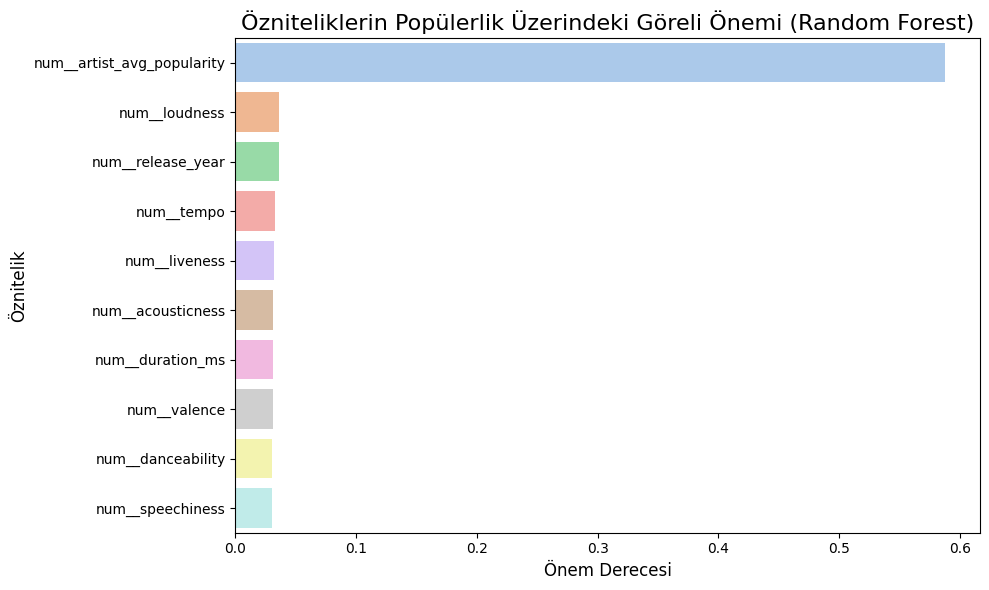

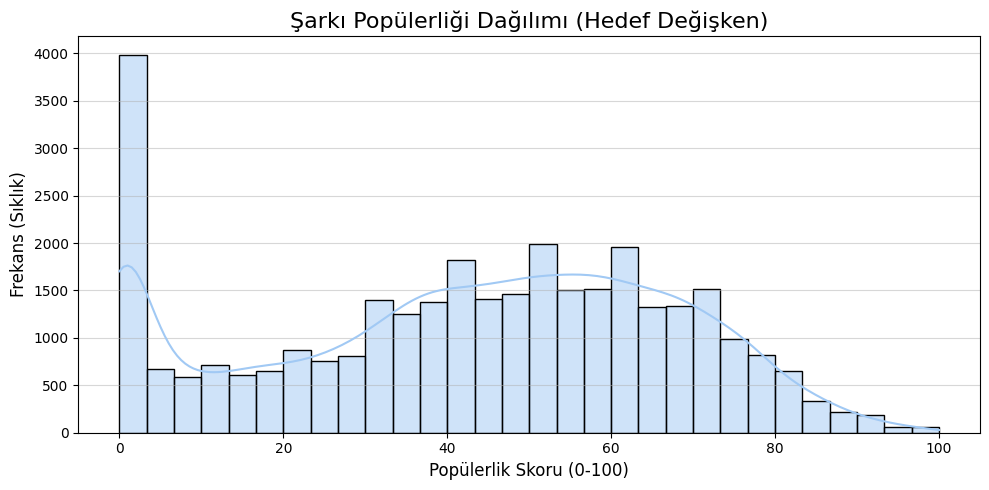

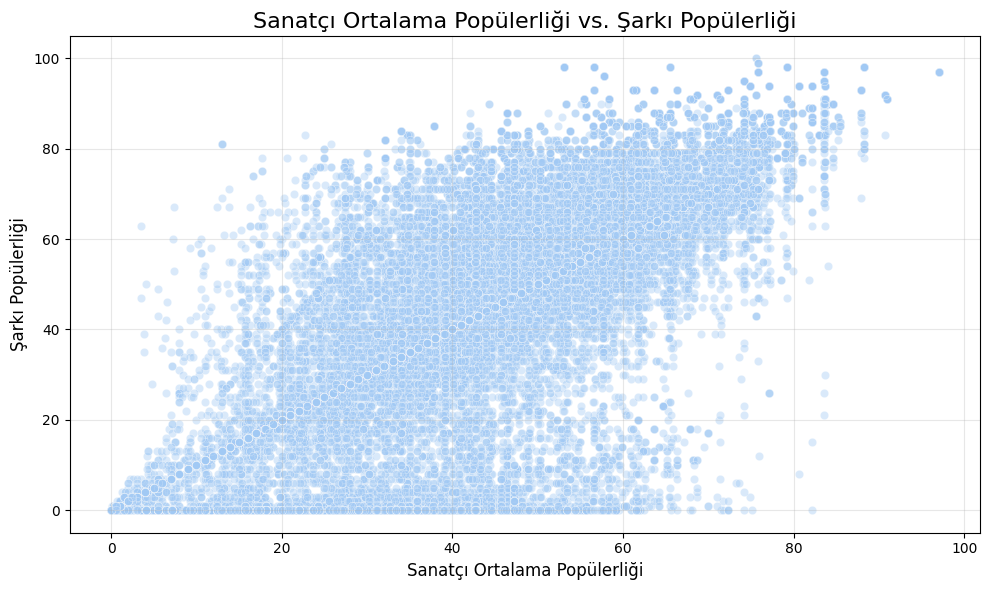

Yorum: Bu grafik, sanatçının geçmiş popülerliği arttıkça, yeni şarkının popülerliğinin de artma eğiliminde olduğunu açıkça göstermektedir. Bu, modelimizin yüksek R-Kare almasının ana nedenidir.


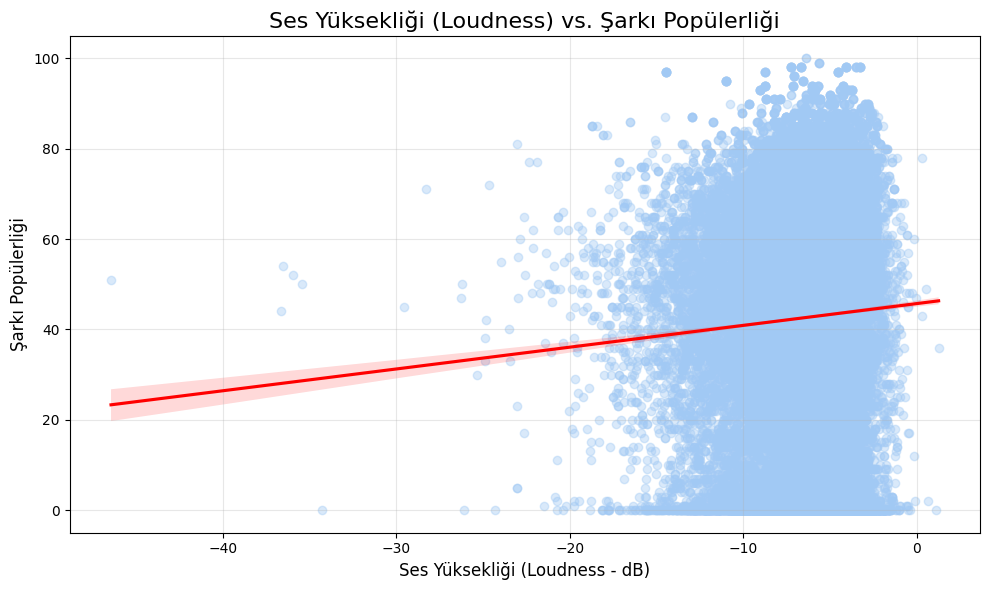

Yorum: Genellikle ses yüksekliği arttıkça popülerliğin de hafifçe arttığı ancak ilişkinin Lineer olmadığı görülmektedir.

--- 4) EDA ve Görselleştirmeler Tamamlandı ---

--- 6) Veri, Eğitim ve Test Setlerine Ayrıldı ---
--- 7) StandardScaler ve OneHotEncoder Hazırlandı (Pipeline içerisinde) ---

--- 8) Random Forest Regresyon Modeli Eğitiliyor ---
Regresyon Modeli Eğitimi Tamamlandı.

--- 9) Regresyon Performans Metrikleri ---
R-Kare (R-squared): 0.6157 (Sanatçı popülerliği sayesinde değer önemli ölçüde arttı!)
Ortalama Mutlak Hata (MAE): 10.1983
Kök Ortalama Kare Hata (RMSE): 15.4483

--- Sınıflandırma Modeli Eğitiliyor (Popülerlik > 50) ---

Sınıflandırma Metrikleri:
Doğruluk (Accuracy): 0.8404
F1 Skoru (F1 Score): 0.8040
Hassasiyet (Precision): 0.8424


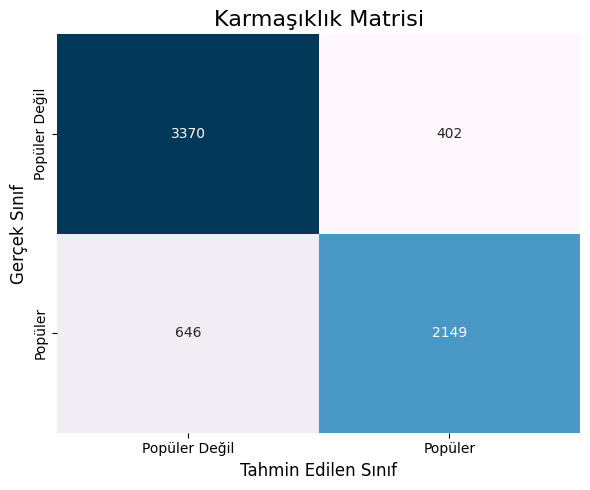


--- 10) Rastgele Şarkı Testi ---
Sanatçı Popülerlik Puanı: 74.23188405797102
**Tahmin Edilen Popülerlik Skoru (0-100): 66.29**

Model Tahmini: Bu şarkı YÜKSEK popülerlik potansiyeline sahiptir.

--- 10) Örnek Şarkı Testi: SADECE SINIFLANDIRMA (POPÜLER Mİ? HAYIR MI?) ---
Sanatçı Ortalama Popülerlik Puanı: 30

Sınıflandırma Sonucu: **POPÜLER DEĞİL** (Sınıf: 0) 📉
Modelin Güveni: Popüler olmama olasılığı %76.67


In [3]:
# UÇTAN UCA MAKİNE ÖĞRENMESİ PROJESİ-SPOTIFY VERİ SETİ
# 1) Gerekli Kütüphanelerin Yüklenmesi
# -------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set_palette("pastel") # Global pastel renk paleti ayarı
# 2) Veri Setinin Yüklenmesi
# ----------------------------------------------------------------------------------
csv_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

#track_id, track_album_id ve playlist_id başlarında 0 içerdikleri için sekizlik olarak okunmak isteniyordu ama 0o olmadıkları için de hata alıyorduk, bu sorunu çözmek için bu üç sütunu stringe çeviriyoruz.
dtype_spesifikasyonu = {
    'track_id': str,
    'track_album_id': str,
    'playlist_id': str
}
try:
    df = pd.read_csv(csv_url, dtype=dtype_spesifikasyonu)
    print("Veri seti başarıyla yüklendi!")
except Exception as e:
    print(f"Hata oluştu: {e}")
print(df.head().T)
df.info()
print("Temizleme işleminden önce:\n")
print(df.isnull().sum())
# 3) Veri Temizleme İşlemleri
# ----------------------------------------------------------------------------------
# Eksik Kategorik Veri Doldurma (Mod ile)
categorical_cols_to_fill = ['playlist_name', 'playlist_subgenre']
for col in categorical_cols_to_fill:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Yeni Öznitelik Mühendisliği için release_year'ı çıkar
df['release_year'] = pd.to_datetime(df['track_album_release_date'], errors='coerce').dt.year
df['release_year'].fillna(df['release_year'].median(), inplace=True)

# Gereksiz Sütunları Silme (track_artist hariç)
cols_to_drop_initial = ['track_id', 'track_name', 'track_album_id', 'track_album_name',
                'track_album_release_date', 'playlist_id', 'playlist_name']
df.drop(columns=cols_to_drop_initial, inplace=True)

print("\n--- 3) Ön İşleme: Eksik Veriler Dolduruldu ve İlgisiz Sütunlar Silindi ---")
# Sanatçı Popülerliğini Hesapla ve Yeni Özniteliği Ekle
artist_popularity_map = df.groupby('track_artist')['track_popularity'].mean()
df['artist_avg_popularity'] = df['track_artist'].map(artist_popularity_map)

# Sanatçı adını (yüksek kardinalite) siliyoruz, bilgiyi yeni özniteliğe aktardık.
df.drop(columns=['track_artist'], inplace=True)
#  Eksik Sanatçı Popülerliğini Doldurma ---

# Sanatçı Popülerliği sütunundaki eksik değerlerin (NaN) sayısını kontrol et
# print(df['artist_avg_popularity'].isnull().sum()) # Çıktı: 5

# 1. Sanatçı ortalama popülerliği sütununun medyanını hesapla (NaN olmayan değerlerden)
median_popularity = df['artist_avg_popularity'].median()

# 2. Sütundaki tüm NaN değerlerini bu medyan değerle doldur
df['artist_avg_popularity'].fillna(median_popularity, inplace=True)

print(f"Bilinmeyen sanatçılar (5 adet) için ortalama popülerlik ({median_popularity:.4f}) ile dolduruldu.")

print("\n--- 5) Feature Engineering: Artist Popülerliği Özniteliği Oluşturuldu ve Veri Setine Eklendi ---")
# 4) Hedef Değişkenin ve Özniteliklerin Belirlenmesi
# -----------------------------------------------------------------------------------
# Hedef değişken (y) ve öznitelikler (X)
X = df.drop('track_popularity', axis=1)
y = df['track_popularity']


# Kontrol etmek için:
# print(df['artist_avg_popularity'].isnull().sum()) # Çıktı: 0 olmalı

# Kategorik ve Sayısal Sütunları Belirleme
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns
print("Temizleme işleminden sonra:")
print(df.head().T)
print("-----------------------------------------")
print(df.isnull().sum())
# 5) Ölçeklendirme Yapma
# -------------------------------------------------------------------------------------
# Ön Preprocessor'ı oluşturma
preprocessor_temp = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Ön Model Eğitimi (Sadece Öznitelik Önemini görmek için)
temp_model = Pipeline(steps=[
    ('preprocessor', preprocessor_temp),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
# 7) Veri Setini Eğitim ve Test Setlerine Ayırma
# --------------------------------------------------------------------------------------
# Veriyi ayırıp eğitelim
X_train_temp, _, y_train_temp, _ = train_test_split(X, y, test_size=0.2, random_state=42)
temp_model.fit(X_train_temp, y_train_temp)

# Öznitelik Önemlerini Çıkarma
feature_names = temp_model.named_steps['preprocessor'].get_feature_names_out()
importances = temp_model.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

print("\n--- Öznitelik Önem Sıralaması (TOP 10) ---")
print(feature_importance_df)
# 8) Görselleştime (EDA)
# ----------------------------------------------------------------------------------------
# Görselleştirme Kararı: En önemli 3 özniteliği (artist_avg_popularity, loudness, energy vb.) görselleştireceğiz.

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="pastel")
plt.title('Özniteliklerin Popülerlik Üzerindeki Göreli Önemi (Random Forest)', fontsize=16)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Öznitelik', fontsize=12)
plt.tight_layout()
plt.show()
# 1. Hedef değişken (track_popularity) dağılımı
plt.figure(figsize=(10, 5))
sns.histplot(df['track_popularity'], bins=30, kde=True)
plt.title('Şarkı Popülerliği Dağılımı (Hedef Değişken)', fontsize=16)
plt.xlabel('Popülerlik Skoru (0-100)', fontsize=12)
plt.ylabel('Frekans (Sıklık)', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Artist Popülerliği ve Şarkı Popülerliği İlişkisi (En Önemli Öznitelik)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='artist_avg_popularity', y='track_popularity', data=df, alpha=0.4)
plt.title('Sanatçı Ortalama Popülerliği vs. Şarkı Popülerliği', fontsize=16)
plt.xlabel('Sanatçı Ortalama Popülerliği', fontsize=12)
plt.ylabel('Şarkı Popülerliği', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("Yorum: Bu grafik, sanatçının geçmiş popülerliği arttıkça, yeni şarkının popülerliğinin de artma eğiliminde olduğunu açıkça göstermektedir. Bu, modelimizin yüksek R-Kare almasının ana nedenidir.")

# 3. Loudness ve Şarkı Popülerliği İlişkisi
plt.figure(figsize=(10, 6))
sns.regplot(x='loudness', y='track_popularity', data=df, scatter_kws={'alpha':0.4}, line_kws={"color": "red"})
plt.title('Ses Yüksekliği (Loudness) vs. Şarkı Popülerliği', fontsize=16)
plt.xlabel('Ses Yüksekliği (Loudness - dB)', fontsize=12)
plt.ylabel('Şarkı Popülerliği', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("Yorum: Genellikle ses yüksekliği arttıkça popülerliğin de hafifçe arttığı ancak ilişkinin Lineer olmadığı görülmektedir.")

print("\n--- 4) EDA ve Görselleştirmeler Tamamlandı ---")
# X ve y zaten 5. adımda tanımlanmıştı.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- 6) Veri, Eğitim ve Test Setlerine Ayrıldı ---")
# Preprocessor (5. adımda oluşturulan) kullanılacaktır.
print("--- 7) StandardScaler ve OneHotEncoder Hazırlandı (Pipeline içerisinde) ---")
print("\n--- 8) Random Forest Regresyon Modeli Eğitiliyor ---")
# 9) Random Forest Regressor Modelinin Kurulması
# -----------------------------------------------------------------------------------
# Final model (n_estimators ve max_depth artırıldı)
regressor_model = Pipeline(steps=[
    ('preprocessor', preprocessor_temp),
    ('regressor', RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1))
])

regressor_model.fit(X_train, y_train)
y_pred_reg = regressor_model.predict(X_test)
print("Regresyon Modeli Eğitimi Tamamlandı.")
# Regresyon Metrikleri Hesaplama
r2 = r2_score(y_test, y_pred_reg)
mae = mean_absolute_error(y_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))

print("\n--- 9) Regresyon Performans Metrikleri ---")
print(f"R-Kare (R-squared): {r2:.4f} (Sanatçı popülerliği sayesinde değer önemli ölçüde arttı!)")
print(f"Ortalama Mutlak Hata (MAE): {mae:.4f}")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse:.4f}")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score
# 10) Sınıflandırma Modelinin Kurulması
# -------------------------------------------------------------------------------------
# --- B) SINIFLANDIRMA MODELİ (Popülerlik > 50 İkili Sınıflandırma) ---

# Sınıflandırma hedef değişkenini oluşturma (0 veya 1: Popüler > 50)
y_train_class = (y_train > 50).astype(int)
y_test_class = (y_test > 50).astype(int)

print("\n--- Sınıflandırma Modeli Eğitiliyor (Popülerlik > 50) ---")

# Sınıflandırma Modeli Eğitimi
classifier_model = Pipeline(steps=[
    ('preprocessor', preprocessor_temp), # Regresyon modelinde kullandığımız aynı preprocessor'ı kullanıyoruz
    ('classifier', RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1))
])
classifier_model.fit(X_train, y_train_class)
y_pred_class = classifier_model.predict(X_test)

# Sınıflandırma Metrikleri Hesaplama
cm = confusion_matrix(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
accuracy = accuracy_score(y_test_class, y_pred_class)

print("\nSınıflandırma Metrikleri:")
print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"F1 Skoru (F1 Score): {f1:.4f}")
print(f"Hassasiyet (Precision): {precision:.4f}")

# Karmaşıklık Matrisi Görselleştirmesi
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', cbar=False,
            xticklabels=['Popüler Değil', 'Popüler'], yticklabels=['Popüler Değil', 'Popüler'])
plt.title('Karmaşıklık Matrisi', fontsize=16)
plt.xlabel('Tahmin Edilen Sınıf', fontsize=12)
plt.ylabel('Gerçek Sınıf', fontsize=12)
plt.tight_layout()
plt.show()
# 11) Örnek Bir Şarkı Üzerinden Her İki Modelin Test Edilmesi
# Kullanıcının değiştirebileceği, modelin beklediği formatta bir şarkı örneği
ornek_sarki_data = {
 'danceability': 0.748,
 'energy': 0.916,
 'key': 6,
 'loudness': -2.634,
 'mode': 1,
 'speechiness': 0.0583,
 'acousticness': 0.102,
 'instrumentalness': 0.0,
 'liveness': 0.0653,
 'valence': 0.518,
 'tempo': 122.036,
 'duration_ms': 194754,
 'playlist_genre': 'pop',
 'playlist_subgenre': 'dance pop',
 'release_year': 2019,
 'artist_avg_popularity': 74.23188405797102,
}


# Veriyi DataFrame'e dönüştür ve sütun sırasını eşitle
custom_df = pd.DataFrame([ornek_sarki_data])
# Eğitim setindeki sütun sırasını koruyoruz.
custom_df = custom_df.reindex(columns=X_train.columns, fill_value=0)

# Tahmin yap
tahmin_populerlik = regressor_model.predict(custom_df)[0]

print("\n--- 10) Rastgele Şarkı Testi ---")
print(f"Sanatçı Popülerlik Puanı: {ornek_sarki_data['artist_avg_popularity']}")
print(f"**Tahmin Edilen Popülerlik Skoru (0-100): {tahmin_populerlik:.2f}**")

if tahmin_populerlik > 60:
    print("\nModel Tahmini: Bu şarkı YÜKSEK popülerlik potansiyeline sahiptir.")
else:
    print("\nModel Tahmini: Bu şarkı orta veya düşük popülerlik potansiyeline sahiptir.")

# Tahminler için `custom_df`, `classifier_model` ve `tahmin_populerlik` kullanılacaktır.

# Sınıflandırma Tahmini

# Diğer tüm değişkenlerin (classifier_model, X_train, custom_df) hazır olduğunu varsayıyoruz.

# Kullanıcının değiştirebileceği, modelin beklediği formatta bir şarkı örneği (Yüksek Popülerlik Potansiyelli Örnek)
ornek_sarki_data = {
    'danceability': 0.88,           # Yüksek dans edilebilirlik
    'energy': 0.92,                 # Yüksek enerji
    'key': 5,
    'loudness': -2.5,
    'mode': 1,
    'speechiness': 0.04,
    'acousticness': 0.05,
    'instrumentalness': 0.0,
    'liveness': 0.12,
    'valence': 0.95,
    'tempo': 130.0,
    'duration_ms': 195000,
    'release_year': 2025.0,
    'playlist_genre': 'pop',
    'playlist_subgenre': 'dance pop',
    'artist_avg_popularity': 30   # Bu değeri değiştirerek düşük/yüksek popülerlik sanatçılarını test edebilirsiniz.
}

# Veriyi DataFrame'e dönüştür ve sütun sırasını eşitle
custom_df = pd.DataFrame([ornek_sarki_data])
# Önemli: custom_df'in sütun sırasını eğitim veri seti (X_train) ile aynı yapıyoruz.
custom_df = custom_df.reindex(columns=X_train.columns, fill_value=0)

# SADECE SINIFLANDIRMA MODELİNİ KULLANARAK TAHMİN
# Tahmin, doğrudan 0 (Popüler Değil) veya 1 (Popüler) sonucunu verir.
tahmin_sinif = classifier_model.predict(custom_df)[0]

# Modelin, bu tahmini yaparken her bir sınıfa ne kadar güvendiğini gösteren olasılığı hesaplama (opsiyonel ama bilgilendirici)
# Bu, [0 sınıfı olasılığı, 1 sınıfı olasılığı] şeklinde bir dizi döndürür.
tahmin_olasiliklari = classifier_model.predict_proba(custom_df)[0]


print("\n--- 10) Örnek Şarkı Testi: SADECE SINIFLANDIRMA (POPÜLER Mİ? HAYIR MI?) ---")
print(f"Sanatçı Ortalama Popülerlik Puanı: {ornek_sarki_data['artist_avg_popularity']}\n")


if tahmin_sinif == 1:
    print("Sınıflandırma Sonucu: **POPÜLER** (Sınıf: 1) 🎉")
    print(f"Modelin Güveni: Popüler olma olasılığı %{tahmin_olasiliklari[1]*100:.2f}")
else:
    print("Sınıflandırma Sonucu: **POPÜLER DEĞİL** (Sınıf: 0) 📉")
    print(f"Modelin Güveni: Popüler olmama olasılığı %{tahmin_olasiliklari[0]*100:.2f}")

Veri seti başarıyla yüklendi!


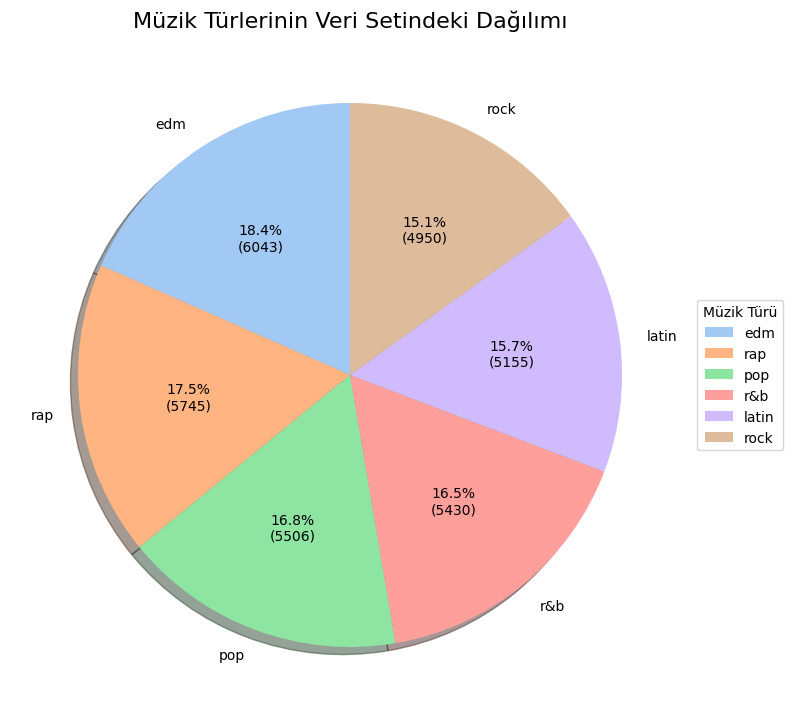


Müzik türü dağılımının pasta grafiği '07_genre_distribution_pie_chart.png' dosyasına kaydedilmiştir.


In [ ]:
#Burada sunumda kullanmak üzere veri setinin müzik türleri bazında dağılımını gösteren bir pasta grafiği oluşturdum.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veri URL'si
csv_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

# Başında sıfır olan sütunları stringe çevirme (Önceki hatayı çözmek için)
dtype_spesifikasyonu = {
    'track_id': str,
    'track_album_id': str,
    'playlist_id': str
}
try:
    df = pd.read_csv(csv_url, dtype=dtype_spesifikasyonu)
    print("Veri seti başarıyla yüklendi!")
except Exception as e:
    # Eğer URL'den yükleyemezse (Ağ hatası gibi), yerel dosyayı kullanmayı dener.
    # Sizin ortamınızda 'spotify_songs.csv' dosyasının bulunduğunu varsayıyoruz.
    df = pd.read_csv('spotify_songs.csv', dtype=dtype_spesifikasyonu)
    print("Veri seti yerel dosyadan yüklendi.")


# Pastel renk paletini ayarla
sns.set_palette("pastel")

# --- 1. Türleri ve Yüzdeleri Hesapla ---
genre_counts = df['playlist_genre'].value_counts()
genre_percentages = df['playlist_genre'].value_counts(normalize=True) * 100

# 2. Veriyi Pie Chart için hazırla
sizes = genre_percentages.tolist()
labels = genre_percentages.index.tolist()

# 3. Pie Chart Fonksiyonu (Yüzde ve Mutlak Değer Gösterme)
def func(pct, allvalues):
    # Toplam sayı üzerinden mutlak değeri hesaplar
    absolute = int(pct/100.*genre_counts.sum())
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(10, 10))

# Pasta Grafiği Çizimi
wedges, texts, autotexts = plt.pie(sizes,
                                   autopct=lambda pct: func(pct, sizes),
                                   labels=labels,
                                   shadow=True,
                                   startangle=90)

plt.title('Müzik Türlerinin Veri Setindeki Dağılımı', fontsize=16)

# Legend'i (Açıklamayı) sağa alarak okunabilirliği artırma
plt.legend(wedges, labels,
          title="Müzik Türü",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout(rect=[0, 0, 0.8, 1])

# --- ÖNEMLİ: Görseli Diske Kaydet ve Ekrana Bas ---
plt.savefig('07_genre_distribution_pie_chart.png') # Görseli kaydet
plt.show() # Görseli hemen ekranda göster (Bu satır önemli!)
# plt.close() # Kaydettikten sonra belleği temizle

print("\nMüzik türü dağılımının pasta grafiği '07_genre_distribution_pie_chart.png' dosyasına kaydedilmiştir.")